# Goals: rebuild Random Forest Classifier from scratch

Use only python and some basic numpy function (numpy slicing, np.mean, np.nonzero)

Produce comparable results to Sklearn Ramdon Forest on some classification dataset

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn import metrics
from sklearn.tree import export_graphviz
import IPython,graphviz
import re
import matplotlib.pyplot as plt
np.random.seed(42)

In [3]:
# fast.ai fnc
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    """ Draws a representation of a random forest in IPython.
    Parameters:
    -----------
    t: The tree you wish to draw
    df: The data used to train the tree. This is used to get the names of the features.
    """
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

In [4]:
class TreeBagging():
    def __init__(self, x, y, n_trees, sample_sz, min_leaf=3):
        np.random.seed(42)
        if hasattr(y,'values'): y = y.values
        self.x,self.y,self.sample_sz,self.min_leaf = x,y,sample_sz,min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        # generate random idxs with size sample_sz
        rnd_idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        return DecisionTreeClassifier(self.x.iloc[rnd_idxs].values, self.y[rnd_idxs], min_leaf=self.min_leaf)        
    def predict_proba(self, x):
        if hasattr(x,'values'): x = x.values
        return np.mean([t.predict_proba(x) for t in self.trees], axis=0)

In [5]:
def logloss(y,y_pred):
    y = np.squeeze(y)
    y_pred= np.clip(np.squeeze(y_pred),1e-5,1-1e-5)
    return np.mean(-np.log(y_pred)*y - np.log(1-y_pred)*(1-y))


class DecisionTreeClassifier():
    def __init__(self, x, y, min_leaf=3):
        self.x,self.y,self.min_leaf = x,y,min_leaf        
        self.n,self.c = len(y), x.shape[1]
        if self.x.shape[0] != self.n:
            raise ValueError('x and y don\'t have the same size')            
        self.val = np.mean(y)
        
        # Metric (loss score)
        self.score = float('inf') # initialize to infinity for a leaf
        
        self.col_idx= -1 # index of column chosen to split
        self.split_value = None # chosen split value from col with col_idx
        
        self.lhs_tree = None
        self.rhs_tree = None
        
        self.find_varsplit()

        
    def find_varsplit(self):
        # Assuming max_feature = self.c, as we consider all features for splitting
        for i in range(self.c): self.find_better_split(i)
        if self.is_leaf: return
        x= self.split_col
        lhs_idx = np.nonzero(x<=self.split_value)[0]
        rhs_idx = np.nonzero(x>self.split_value)[0]
        
        self.lhs_tree = DecisionTreeClassifier(self.x[lhs_idx,:], self.y[lhs_idx])
        self.rhs_tree = DecisionTreeClassifier(self.x[rhs_idx,:], self.y[rhs_idx])

    def find_better_split(self, col_idx): 
        x = self.x[:,col_idx]
        y = self.y

        sort_idx = np.argsort(x)
        sort_x,sort_y = x[sort_idx],y[sort_idx]
        rhs_cnt,rhs_sum = self.n,sort_y.sum()
        lhs_cnt,lhs_sum=0,0.0
        
        for i in range(0,self.n- self.min_leaf):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            if i<self.min_leaf-1 or xi==sort_x[i+1]: # cannot split at a duplicate. ALl dups should be in 1 side
                continue
            lhs_pred = np.array([lhs_sum/lhs_cnt] * lhs_cnt)
            rhs_pred = np.array([rhs_sum/rhs_cnt] * rhs_cnt)
            pred_at_split = np.concatenate([lhs_pred,rhs_pred])
            curr_score = logloss(sort_y,pred_at_split) #binary log loss score
            if curr_score<self.score: 
                self.col_idx,self.score,self.split_value = col_idx,curr_score,xi
    
    
    @property
    def split_col(self): 
        return self.x[:,self.col_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    #prediction
    def predict_proba(self,x):
        return np.array([self.predict_row(xi) for xi in x])
    def predict_row(self,xi):
        if self.is_leaf: return self.val
        subtree = self.lhs_tree if xi[self.col_idx]<=self.split_value else self.rhs_tree
        return subtree.predict_row(xi)
    
    def __repr__(self):
        ll = logloss(self.y, np.array([self.val]*self.n))
        s = f'Sample size: {self.n}. Predict_proba value: {self.val:0.5f}. Log loss: {ll:0.5f}\n'
        if not self.is_leaf:
            s += f'Best split from feature {self.col_idx} at value {self.split_value}.  Best split\'s Log Loss Score:{self.score:0.5f}'
        return s

# Generate a fake dataset

In [6]:
nrows=20
df = pd.DataFrame(np.random.randint(1,10,(nrows,2)),columns=list('ab'))
df['y'] = np.random.randint(0,2,(20,))
print(df.head())
y = df.y.values
df.drop('y',axis=1,inplace=True)

   a  b  y
0  7  4  1
1  8  5  0
2  7  3  1
3  7  8  1
4  5  4  1


# Check whether my RF splits are valid against sklearn's Random Forest

Since Sklearn RF classifier uses Gini to split and I use binary log loss to split, it won't be possible to draw tree and compare split points as I did in RF regressor notebook. This step is skipped

# Benchmarking on fake dataset

In [13]:
nrows=1000
ncols=10
df = pd.DataFrame(np.random.randint(1,10,(nrows,ncols)))
df['y'] = np.random.randint(0,2,(nrows,))
y = df.y.values
df.drop('y',axis=1,inplace=True)

In [14]:
rf = RandomForestClassifier(n_estimators=5,bootstrap=False,min_samples_leaf=3)
rf.fit(df,y)

rf_pred = rf.predict_proba(df)[:,1]
print(f'Log loss score: {logloss(y,rf_pred)}')
print(f'AUC score: {metrics.roc_auc_score(y,rf_pred)}')

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Log loss score: 0.2515651862164532
AUC score: 0.9991737322892617


In [15]:
tb = TreeBagging(df, y, n_trees=5, sample_sz=nrows)
tb_pred = tb.predict_proba(df)
print(f'Log loss score: {logloss(y,tb_pred)}')
print(f'AUC score: {metrics.roc_auc_score(y,tb_pred)}')

Log loss score: 0.1928606755909865
AUC score: 0.9735314241814348


Results are comparable!

# Benchmarking: Wisconsin Breast Cancer prediction

The Breast Cancer datasets is available machine learning repository maintained by the University of California, Irvine. The dataset contains 569 samples of malignant and benign tumor cells.

- The first two columns in the dataset store the unique ID numbers of the samples and the corresponding diagnosis (M=malignant, B=benign), respectively.
- The columns 3-32 contain 30 real-value features that have been computed from digitized images of the cell nuclei, which can be used to build a model to predict whether a tumor is benign or malignant.

This dataset's missing values are already handled.

In [16]:
data = pd.read_csv("data/cancer.csv")
print(data.shape)
data.head()

(569, 32)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [17]:
data.dtypes

id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

In [18]:
# some preprocessing
target = data['diagnosis'].apply(lambda row: 1 if row=='M' else 0)

data.drop(['id','diagnosis'],axis=1,inplace=True)

In [19]:
from sklearn.model_selection import train_test_split
def get_train_val(X,y):
    X_train,X_val,y_train,y_val =  train_test_split(X, y, test_size=0.15, random_state=42)
    return X_train.reset_index(drop=True),X_val.reset_index(drop=True),y_train,y_val

In [20]:
X_train,X_val,y_train,y_val = get_train_val(data,target)

### sklearn Random Forest

In [33]:
rf = RandomForestClassifier(n_estimators=20,max_depth=4,bootstrap=False,min_samples_leaf=5)
rf.fit(X_train,y_train)

rf_train_pred = rf.predict_proba(X_train)[:,1]
rf_val_pred = rf.predict_proba(X_val)[:,1]

print(f'Log loss train score: {logloss(y_train,rf_train_pred)}')
print(f'Log loss val score: {logloss(y_val,rf_val_pred)}')
print(f'AUC train score: {metrics.roc_auc_score(y_train,rf_train_pred)}')
print(f'AUC val score: {metrics.roc_auc_score(y_val,rf_val_pred)}')

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Log loss train score: 0.0712527806482825
Log loss val score: 0.11126467398267259
AUC train score: 0.998001466813348
AUC val score: 0.9971064814814815


In [34]:
%matplotlib inline

Text(33,0.5,'True label')

Text(0.5,15,'Predicted label')

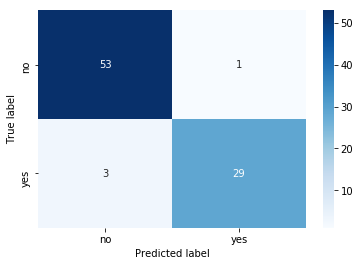

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Compute confusion matrix for a model
cm = confusion_matrix(y_val, rf.predict(X_val))

# view with a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.ylabel('True label')
plt.xlabel('Predicted label')

## 'Scratch' Random Forest

One possible thing I can tune here but not in sklearn Random Forest is the size of data subset for each tree (sample_sz)

In [36]:
X_train.shape[0]

483

In [37]:
%%time
tb = TreeBagging(X_train, y_train, n_trees=30, sample_sz=100,min_leaf=5)

CPU times: user 16.6 s, sys: 19.1 ms, total: 16.6 s
Wall time: 16.6 s


In [38]:
tb_train_pred = tb.predict_proba(X_train)
tb_val_pred = tb.predict_proba(X_val)
print(f'Log loss train score: {logloss(y_train,tb_train_pred)}')
print(f'Log loss val score: {logloss(y_val,tb_val_pred)}')
print(f'AUC train score: {metrics.roc_auc_score(y_train,tb_train_pred)}')
print(f'AUC val score: {metrics.roc_auc_score(y_val,tb_val_pred)}')

Log loss train score: 0.09982702544018603
Log loss val score: 0.1046549212365378
AUC train score: 0.9964338100476714
AUC val score: 0.9959490740740741


Los loss score is a little bit better than Sklearn RF

Text(33,0.5,'True label')

Text(0.5,15,'Predicted label')

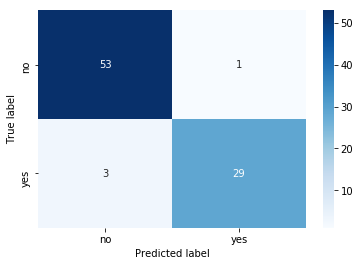

In [39]:
# Compute confusion matrix for a model
cm = confusion_matrix(y_val, tb_val_pred>=0.5)

# view with a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.ylabel('True label')
plt.xlabel('Predicted label')

'Scratch' RF classifier is able to draw a comparable result to sklearn Random Forest

# Calculate feature importance

Feature importance will be calculated by using **permutation importance**. There is an argument which is mentioned in this [doc](http://parrt.cs.usfca.edu/doc/rf-importance/index.html#3) that feature importance calculated in sklearn is misleading. SKlearn used **mean decrease in impurity (gini improtance)**, which does not always give an accurate picture of importance. 

On the other hand, **permutation importance** is calculated as follows: Record a baseline accuracy (classifier) or R2 score (regressor) by passing a validation set or the out-of-bag (OOB) samples through the Random Forest. Permute the column values of a single predictor feature and then pass all test samples back through the Random Forest and recompute the accuracy or R2. The importance of that feature is the difference between the baseline and the drop in overall accuracy or R2 caused by permuting the column. This is more expensive to calculate, but results are more reliable

In [40]:
def metric(rf,X_val,y_val):
    y_val_pred = rf.predict_proba(X_val)
    if len(y_val_pred.shape) ==2:
        y_val_pred = y_val_pred[:,1]
    return logloss(y_val,y_val_pred)

def permutation_importances(rf,X_val,y_val,metric):
    baseline = metric(rf,X_val,y_val)
    imp=[]
    for col in X_val.columns:
        save = X_val[col].copy()
        X_val[col] = np.random.permutation(X_val[col])
        m = metric(rf,X_val,y_val)
        X_val[col] = save
        imp.append(m-baseline)
    return np.array(imp)

## Feature importance from Sklearn's RF model

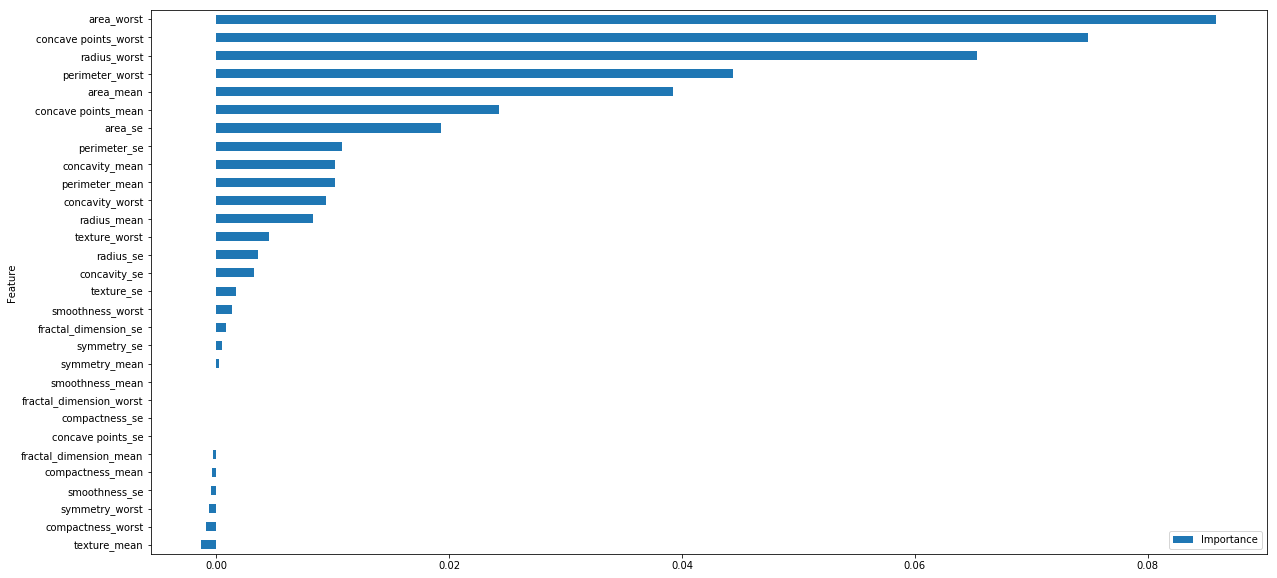

In [41]:
fea_imp = permutation_importances(rf,X_val,y_val,metric)
fea_imp_df = pd.DataFrame(data={'Feature':X_val.columns,'Importance':fea_imp})
fea_imp_df = fea_imp_df.set_index('Feature')
fea_imp_df = fea_imp_df.sort_values('Importance', ascending=True)
fea_imp_df.plot(kind='barh',figsize=(20,10))

# Feature importance from 'scratch' RF

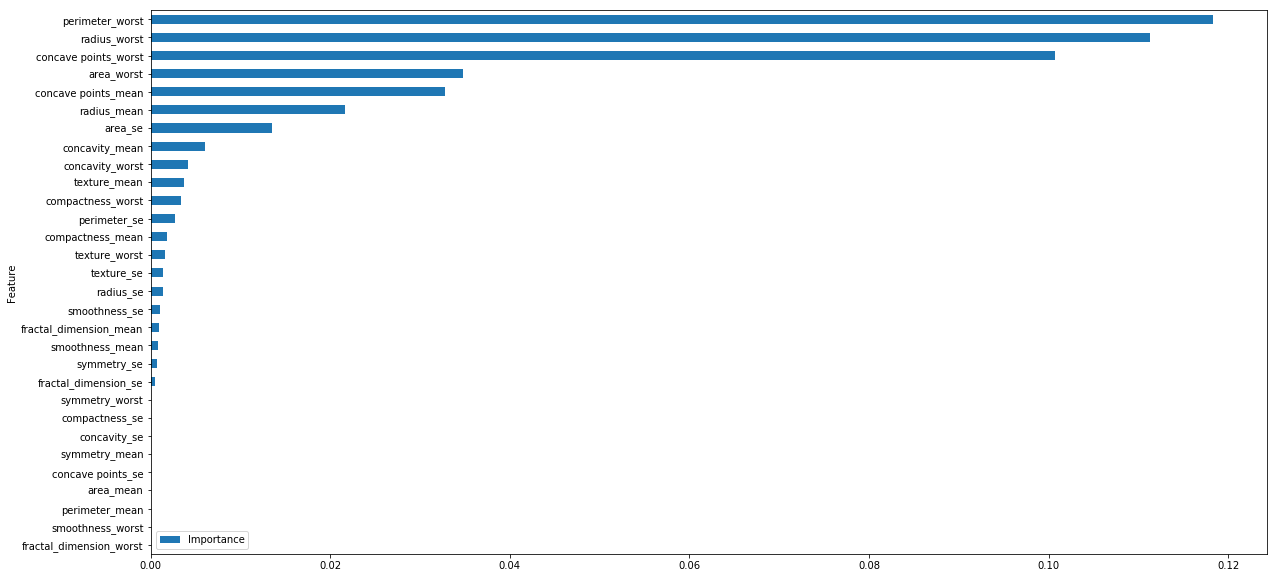

In [42]:
fea_imp = permutation_importances(tb,X_val,y_val,metric)
fea_imp_df = pd.DataFrame(data={'Feature':X_val.columns,'Importance':fea_imp})
fea_imp_df = fea_imp_df.set_index('Feature')
fea_imp_df = fea_imp_df.sort_values('Importance', ascending=True)
fea_imp_df.plot(kind='barh',figsize=(20,10))

Even with different implementation, 'scratch' Random Forest classifier is consistent with Sklearn RF in its first 10 important features.